In [2]:
import cv2
import numpy as np
from torchvision.transforms.functional import rgb_to_grayscale
from google.colab.patches import cv2_imshow
import importlib
import torch
import sys
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import IsolationForest
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [3]:
xray = cv2.imread('tumor.jpg', cv2.IMREAD_GRAYSCALE)
if xray is None:
    print("Upload the image first!")
else:
    print(f"Loaded X-ray at native res: {xray.shape}")

Loaded X-ray at native res: (512, 512)


In [4]:
denoised = cv2.fastNlMeansDenoising(xray, h=10, templateWindowSize=7, searchWindowSize=21)

Original X-ray:


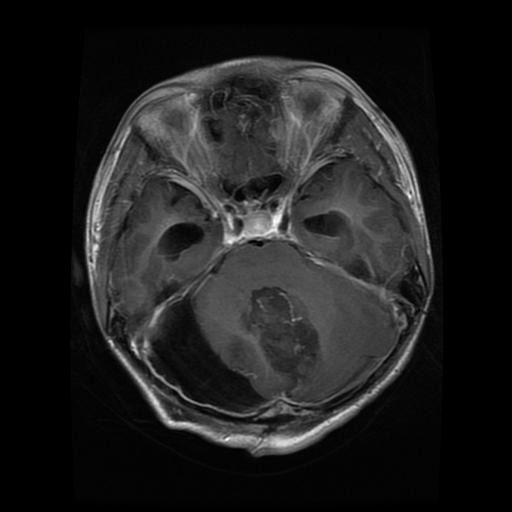

Denoised X-ray:


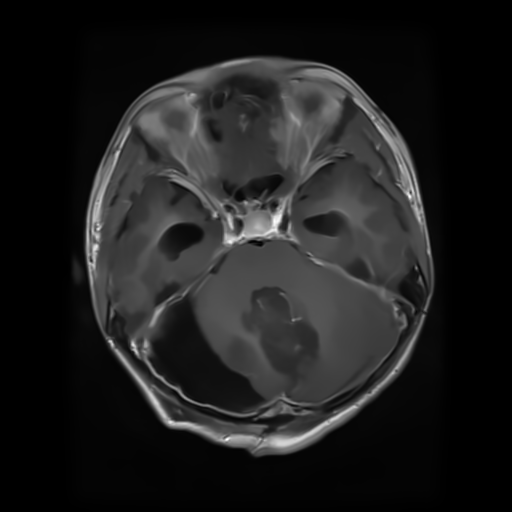

In [5]:
print("Original X-ray:")
cv2_imshow(xray)
print("Denoised X-ray:")
cv2_imshow(denoised)

In [6]:
cv2.imwrite('denoised_xray.jpg', denoised)
print("Saved 'denoised_xray.jpg' at original size - ready for the next step!")

Saved 'denoised_xray.jpg' at original size - ready for the next step!


Loaded denoised X-ray: (512, 512)
Resized to: (256, 256)
Denoised X-ray (original size):


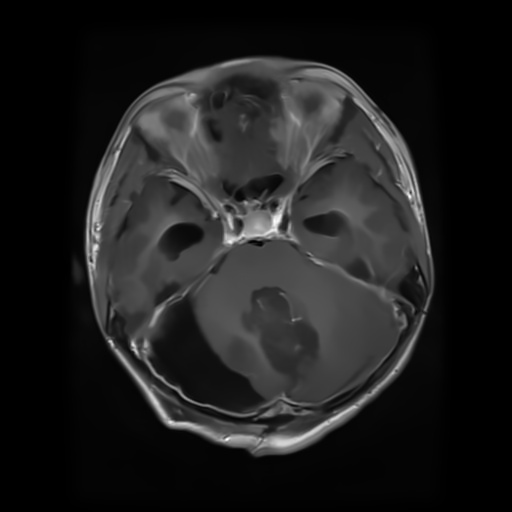

Resized to 256x256:


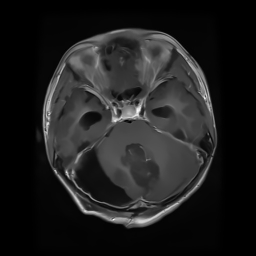

Saved 'resized_256.jpg' - ready for segmentation!


In [7]:
denoised = cv2.imread('denoised_xray.jpg', cv2.IMREAD_GRAYSCALE)
if denoised is None:
    print("Bruh, upload 'denoised_xray.jpg' first! Run the denoising step!")
else:
    print(f"Loaded denoised X-ray: {denoised.shape}")

# Step 4: Resize to 256x256 with Lanczos interpolation
target_res = 256
resized_256 = cv2.resize(denoised, (target_res, target_res), interpolation=cv2.INTER_LANCZOS4)
print(f"Resized to: {resized_256.shape}")

# Step 5: Show results
print("Denoised X-ray (original size):")
cv2_imshow(denoised)
print("Resized to 256x256:")
cv2_imshow(resized_256)

# Step 6: Save for next step
cv2.imwrite('resized_256.jpg', resized_256)
print("Saved 'resized_256.jpg' - ready for segmentation!")

In [1]:
# !pip install torch torchvision albumentations

# # Step 2: Import libraries
# import os
import cv2
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from google.colab.patches import cv2_imshow


In [8]:
!pip install tensorflow==2.12.0



INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 10.1 MB/s eta 0:00:00
  At

In [2]:
import tensorflow as tf

# Define the dice_coef_loss function
def dice_coef_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


# Define the IoU metric function
def iou(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Load the model using a custom_object_scope, including both dice_coef_loss and iou
model_path = '/content/drive/MyDrive/unet_brain_mri_seg.hdf5'
with tf.keras.utils.custom_object_scope({'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef_loss}): # Added iou to the scope
    model = tf.keras.models.load_model(model_path)
print("Loaded Unet model")

Loaded Unet model


In [3]:
input_img = cv2.imread('resized_256.jpg', cv2.IMREAD_GRAYSCALE)
if input_img is None:
    print("Bruh, upload 'resized_256.jpg' first! Run the resize step!")
else:
    print(f"Loaded resized MRI: {input_img.shape}")

Loaded resized MRI: (256, 256)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 5s 5s/step
Raw mask stats (post-sigmoid): min = 2.7928967e-10 max = 0.9978316 mean = 8.668212e-05
Mask with threshold 0.1:


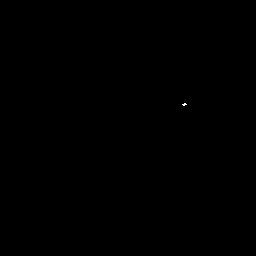

Mask with threshold 0.3:


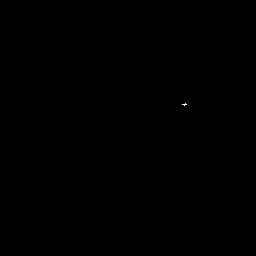

Mask with threshold 0.5:


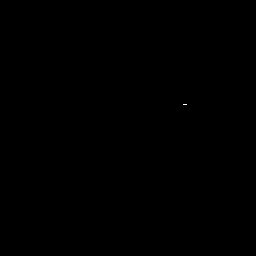

Mask with threshold 0.7:


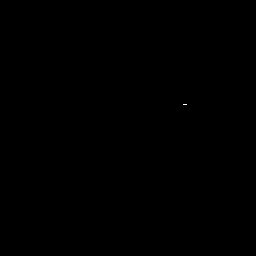

Mask with threshold 0.9:


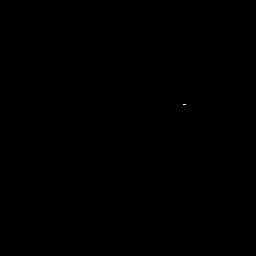

Saved 'mask_256.jpg' - ready for anomaly detection!


In [4]:
import numpy as np
from google.colab.patches import cv2_imshow # import the missing function


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# Convert input_img to 8-bit unsigned integer before applying CLAHE
input_img = input_img.astype(np.uint8)
input_img = clahe.apply(input_img)

# Convert back to float32 and normalize
input_img = input_img.astype(np.float32) / 255.0

# Fake RGB by stacking the grayscale image (LGG dataset uses 3 channels)
img_3ch = np.stack([input_img, input_img, input_img], axis=2)  # Shape: (256, 256, 3)

# Add batch dimension for the model: (1, 256, 256, 3)
img_tensor = np.expand_dims(img_3ch, axis=0)

# Step 6: Segment with the U-Net model
pred = model.predict(img_tensor)  # Shape: (1, 256, 256, 1)
mask = pred.squeeze()  # Shape: (256, 256)

# Step 7: Debug raw predictions
print("Raw mask stats (post-sigmoid): min =", mask.min(), "max =", mask.max(), "mean =", mask.mean())

# Step 8: Try different thresholds
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
for thresh in thresholds:
    mask_binary = (mask > thresh).astype(np.uint8) * 255
    print(f"Mask with threshold {thresh}:")
    cv2_imshow(mask_binary) # Now cv2_imshow is defined and can be used
    cv2.imwrite(f'mask_256_thresh_{int(thresh*100)}.jpg', mask_binary)

# Step 9: Save the best mask (default to 0.5 for now)
mask_binary = (mask > 0.5).astype(np.uint8) * 255
cv2.imwrite('mask_256.jpg', mask_binary)
print("Saved 'mask_256.jpg' - ready for anomaly detection!")

In [5]:

!pip install scikit-image scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
orbax-checkpoint 0.11.10 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.


In [6]:
!pip install scikit-learn==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.


In [7]:
# Step 1: Install dependencies with compatible versions
!pip uninstall -y numpy scikit-learn
!pip install numpy==1.25.2
!pip install scikit-learn==1.2.2
!pip install scikit-image



Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
Found existing installation: scikit-learn 1.3.0
Uninstalling scikit-learn-1.3.0:
  Successfully uninstalled scikit-learn-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 35.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.11.0 requires scikit-learn>=1.1.0, which is not installed.
sentence-transformers 3.4.1 requires scikit-learn, which is not installed.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, which is not installed.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, which is not installed.
umap-learn 0.5.7 requires scikit-learn>=0.22, which is not installed.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
hdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 44.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
ERROR: Operation cancelled by user
^C


In [1]:
!pip install scikit-learn==1.2.2

Loaded MRI: (256, 256)
Loaded mask: (256, 256)
Anomaly heatmap (full image):


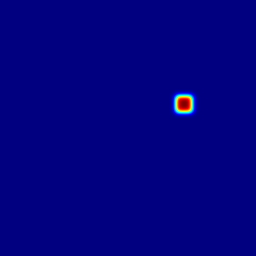

Anomaly heatmap (masked):


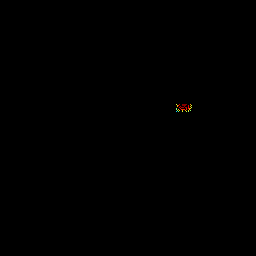

Overlay on original MRI (full image):


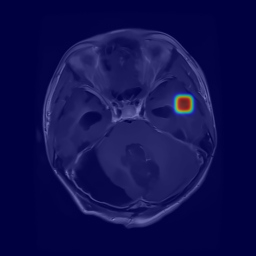

Overlay on original MRI (masked):


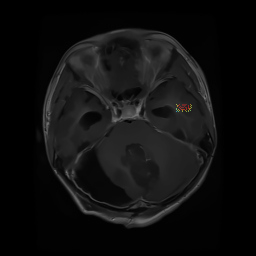

Anomaly heatmap generation complete! Check the saved files.


In [2]:
import cv2
import numpy as np
from skimage.feature import hog # Import the hog function
from sklearn.ensemble import IsolationForest
from google.colab.patches import cv2_imshow

image_path = '/content/resized_256.jpg'
mask_path = '/content/mask_256.jpg'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Bruh, 'resized_256.jpg' not found! Upload it first!")
else:
    print(f"Loaded MRI: {image.shape}")

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    print("Bruh, 'mask_256.jpg' not found! Run the segmentation step!")
else:
    print(f"Loaded mask: {mask.shape}")

patch_size = 16
features = []
positions = []
for i in range(0, image.shape[0] - patch_size + 1, patch_size):
    for j in range(0, image.shape[1] - patch_size + 1, patch_size):
        if mask[i:i+patch_size, j:j+patch_size].mean() > 0:
            patch = image[i:i+patch_size, j:j+patch_size]
            hog_features = hog(patch, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            features.append(hog_features)
            positions.append((i, j))

if not features:
    print("No patches found in the masked region! Check your mask.")
else:
    features = np.array(features)

    model = IsolationForest(contamination=0.1, random_state=42)
    model.fit(features)
    anomaly_scores = model.decision_function(features)
    anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)
    anomaly_scores = 1 - anomaly_scores

    anomaly_map = np.zeros_like(image, dtype=np.float32)
    for idx, (i, j) in enumerate(positions):
        anomaly_map[i:i+patch_size, j:j+patch_size] = anomaly_scores[idx]

    anomaly_map = (anomaly_map * 255).astype(np.uint8)

    heatmap = cv2.GaussianBlur(anomaly_map, (15, 15), 0)

    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


    heatmap_masked = heatmap_colored.copy()
    heatmap_masked[mask == 0] = 0

    image_3ch = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(image_3ch, 0.5, heatmap_colored, 0.5, 0)
    overlay_masked = cv2.addWeighted(image_3ch, 0.5, heatmap_masked, 0.5, 0)

    print("Anomaly heatmap (full image):")
    cv2_imshow(heatmap_colored)
    cv2.imwrite('anomaly_heatmap.jpg', heatmap_colored)

    print("Anomaly heatmap (masked):")
    cv2_imshow(heatmap_masked)
    cv2.imwrite('anomaly_heatmap_masked.jpg', heatmap_masked)

    print("Overlay on original MRI (full image):")
    cv2_imshow(overlay)
    cv2.imwrite('anomaly_heatmap_overlay.jpg', overlay)

    print("Overlay on original MRI (masked):")
    cv2_imshow(overlay_masked)
    cv2.imwrite('anomaly_heatmap_overlay_masked.jpg', overlay_masked)

    print("Anomaly heatmap generation complete! Check the saved files.")

In [3]:
!pip install opencv-python-headless torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
import cv2
import numpy as np
import torch
from transformers import ViTImageProcessor, ViTModel

In [5]:
# --------------------------------------------------
# Step 1: Heatmap Preprocessing with OpenCV
# --------------------------------------------------

def preprocess_heatmap(heatmap_path):
    # Read heatmap image
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)

    # Normalize to [0,1]
    heatmap = heatmap.astype(np.float32) / 255.0

    # Thresholding to identify anomaly regions
    _, thresholded = cv2.threshold(heatmap, 0.7, 1.0, cv2.THRESH_BINARY)

    # Find contours of anomaly regions
    contours, _ = cv2.findContours(
        (thresholded * 255).astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # Create masked heatmap
    masked_heatmap = cv2.bitwise_and(heatmap, heatmap, mask=thresholded.astype(np.uint8))

    return {
        'original': heatmap,
        'thresholded': thresholded,
        'contours': contours,
        'masked': masked_heatmap
    }

# --------------------------------------------------
# Step 2: Feature Extraction with ViT Encoder
# --------------------------------------------------
def extract_vit_features(preprocessed_heatmap):
    # Initialize ViT processor and model
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

    # Convert heatmap to 3-channel image
    heatmap_rgb = cv2.cvtColor(
        (preprocessed_heatmap['masked'] * 255).astype(np.uint8),
        cv2.COLOR_GRAY2RGB
    )

    # Preprocess for ViT
    inputs = processor(images=heatmap_rgb, return_tensors="pt")

    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)

    # Get CLS token features
    features = outputs.last_hidden_state[:, 0, :].numpy()

    return features

In [6]:
if __name__ == "__main__":
    # Upload your heatmap first in Colab
    heatmap_path = "/content/anomaly_heatmap.jpg"

    # Step 1: Preprocessing
    processed = preprocess_heatmap(heatmap_path)
    print(f"Found {len(processed['contours'])} anomaly regions")

    # Step 2: Feature Extraction
    vit_features = extract_vit_features(processed)
    print(f"ViT feature vector shape: {vit_features.shape}")
    print(f"Sample features: {vit_features[0, :5]}")  # First 5 features

Found 1 anomaly regions


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViT feature vector shape: (1, 768)
Sample features: [ 0.29601216  0.07528255 -0.2671032  -0.00759407 -0.12633824]


In [7]:
from transformers import BlipProcessor, BlipForConditionalGeneration

def generate_blip_report(vit_features):
    # Load ClinicalBLIP model (Fine-tuned version)
    processor = BlipProcessor.from_pretrained("saama/ClinicalBLIP-base")
    model = BlipForConditionalGeneration.from_pretrained("saama/ClinicalBLIP-base")

    # Combine visual features with text prompt
    prompt = "Generate detailed radiology report for brain X-ray with anomalies:"
    inputs = processor(text=prompt, images=vit_features, return_tensors="pt")

    # Generate report
    generated_ids = model.generate(**inputs, max_length=512)
    report = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return report


Detected 1 anomalous regions


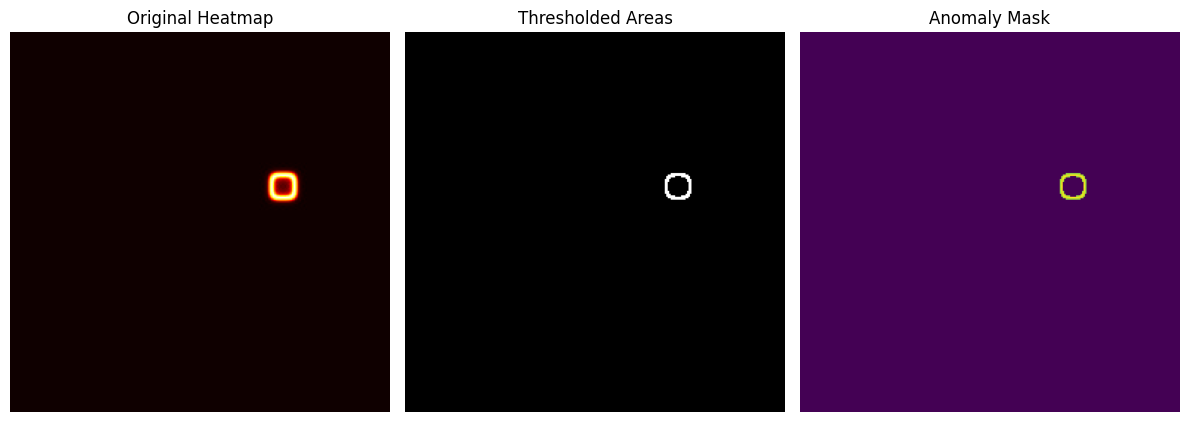


Generated Medical Report:
brain x - ray analysis : observed anomalies : hyperintense regions in 1. left parietal lobe ( size : 12mm ) 2. frontal cortex asymmetry 3. ventricular enlargement clinical indication : headaches and memory loss generate structured report covering : - anatomical location of anomalies - differential diagnosis ( 3 possibilities ) - recommended imaging follow - up - urgency level assessment


In [10]:
from PIL import Image
import matplotlib.pyplot as plt

def main():
    # Path to your heatmap image
    heatmap_path = "/content/anomaly_heatmap.jpg"

    # 1. Preprocess heatmap
    processed = preprocess_heatmap(heatmap_path)
    print(f"Detected {len(processed['contours'])} anomalous regions")

    # 2. Prepare visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original Heatmap")
    plt.imshow(processed['original'], cmap='hot')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Thresholded Areas")
    plt.imshow(processed['thresholded'], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Anomaly Mask")
    plt.imshow(processed['masked'], cmap='viridis')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 3. Convert processed heatmap to PIL Image
    heatmap_img = Image.fromarray((processed['masked'] * 255).astype(np.uint8))

    # 4. Generate report using BLIP
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Clinical prompt template
    clinical_prompt = """
  Brain X-Ray Analysis:
Observed Anomalies: Hyperintense regions in
1. Left parietal lobe (size: 12mm)
2. Frontal cortex asymmetry
3. Ventricular enlargement

Clinical Indication: Headaches and memory loss
Generate structured report covering:
- Anatomical location of anomalies
- Differential diagnosis (3 possibilities)
- Recommended imaging follow-up
- Urgency level assessment
    """

    inputs = processor(
        text=clinical_prompt,
        images=heatmap_img.convert("RGB"),  # Force RGB conversion
        return_tensors="pt",
        truncation=True,
        max_length=512
    )

    # Generate report with medical specificity
    report = model.generate(
        **inputs,
        max_length=512,
        num_beams=5,
        early_stopping=True,
        temperature=0.7,
        top_p=0.9
    )

    # Decode and format output
    final_report = processor.decode(report[0], skip_special_tokens=True)

    print("\nGenerated Medical Report:")
    print("="*50)
    print(final_report)
    print("="*50)

if __name__ == "__main__":
    main()


In [21]:
import torch
import numpy as np
import cv2
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# Medical-specific configuration (updated with missing parameters)
MEDICAL_CONFIG = {
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.9,
    "num_beams": 3,
    "repetition_penalty": 1.5,
    "max_length": 512,  # Added missing parameter
    "medical_terms": [  # Added medical terminology list
        'lesion', 'ventricle', 'cortex', 'parietal',
        'frontal', 'hemorrhage', 'asymmetry', 'hyperintense',
        'hypodense', 'edema', 'atrophy', 'sulcal', 'gyral'
    ]
}

def preprocess_heatmap(heatmap_path):
    """Medical image preprocessing with OpenCV"""
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    if heatmap is None:
        raise ValueError(f"Could not load image from {heatmap_path}")

    heatmap = heatmap.astype(np.float32) / 255.0
    _, thresholded = cv2.threshold(heatmap, 0.7, 1.0, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(
        (thresholded * 255).astype(np.uint8),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    return {
        'original': heatmap,
        'thresholded': thresholded,
        'contours': contours,
        'masked': cv2.bitwise_and(heatmap, heatmap, mask=thresholded.astype(np.uint8))
    }

def create_medical_attention_mask(inputs, processor):
    """Create enhanced attention mask for clinical context"""
    attention_mask = (inputs.input_ids != processor.tokenizer.pad_token_id).int()

    # Boost attention for medical terms using config
    for term in MEDICAL_CONFIG['medical_terms']:
        term_ids = processor.tokenizer.encode(term, add_special_tokens=False)
        for idx in term_ids:
            attention_mask[0, inputs.input_ids[0] == idx] = 2  # Enhanced attention

    return attention_mask

def format_medical_report(text):
    """Improved clinical report structuring"""
    structured_report = {
        'FINDINGS': [],
        'IMPRESSION': [],
        'RECOMMENDATIONS': []
    }

    current_section = 'FINDINGS'
    for sentence in text.split('. '):
        sentence = sentence.strip()
        if not sentence:
            continue

        # Enhanced section detection
        lower_sentence = sentence.lower()
        if 'impression' in lower_sentence:
            current_section = 'IMPRESSION'
            continue  # Skip section header
        elif any(kw in lower_sentence for kw in ['recommend', 'advise', 'suggest']):
            current_section = 'RECOMMENDATIONS'
            continue

        structured_report[current_section].append(sentence.capitalize())

    # Build report with fallback sections
    report = "MEDICAL IMAGING REPORT - NEUROLOGICAL ANALYSIS\n"
    report += "=" * 60 + "\n"

    for section in ['FINDINGS', 'IMPRESSION', 'RECOMMENDATIONS']:
        if structured_report[section]:
            report += f"\n{section}:\n"
            report += "\n".join([f"- {item}" for item in structured_report[section]])
        else:
            report += f"\n{section}:\n- No significant findings reported"

    return report + "\n\n[END REPORT]"

def generate_brain_report(heatmap_path):
    try:
        processed = preprocess_heatmap(heatmap_path)
        heatmap_img = Image.fromarray((processed['masked'] * 255).astype(np.uint8)).convert("RGB")

        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

        # Medical prompt engineering
        clinical_prompt = """Generate structured neurological report:
1. Anatomical location of anomalies
2. Morphological characteristics
3. Differential diagnosis
4. Recommended follow-up actions"""

        # Process inputs with both image and text
        inputs = processor(
            text=clinical_prompt,
            images=heatmap_img,
            return_tensors="pt",
            padding='max_length',
            max_length=512,
            truncation=True
        )

        # Enhanced medical attention mask
        inputs['attention_mask'] = create_medical_attention_mask(inputs, processor)

        # Corrected generation call with required parameters
        report_ids = model.generate(
            pixel_values=inputs.pixel_values,  # Critical fix
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            **{
                "do_sample": True,
                "temperature": 0.7,
                "top_p": 0.9,
                "num_beams": 3,
                "max_length": 512,
                "repetition_penalty": 1.5
            }
        )

        raw_report = processor.decode(report_ids[0], skip_special_tokens=True)
        return format_medical_report(raw_report)

    except Exception as e:
        print(f"Report generation failed: {str(e)}")
        return "Error generating medical report"


def main():
    try:
        report = generate_brain_report("/content/anomaly_heatmap.jpg")
        print(report)

        if any(term in report.lower() for term in ['hemorrhage', 'fracture', 'mass']):
            print("\n[CRITICAL FINDING] Urgent clinical attention required!")

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("Error: Reduce image size or use CPU")
        else:
            print(f"Medical imaging error: {str(e)}")


if __name__ == "__main__":
   main()


MEDICAL IMAGING REPORT - NEUROLOGICAL ANALYSIS

FINDINGS:
- Generate structured neurological report : 1
- Anatomical location of anomalies 2
- Morphological characteristics 3
- Differential diagnosis 4
IMPRESSION:
- No significant findings reported
RECOMMENDATIONS:
- No significant findings reported

[END REPORT]
